In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pedalboard.pedalboard import load_plugin

from src.dataset.audio_dataset import AudioDataset
from src.wrappers.dafx_wrapper import DAFXWrapper

from src.models.linear_vae import LinearVAE

In [19]:
DAFX_TO_USE = [
    'mda Overdrive',
    'mda Delay'
]

In [20]:
DAFX_FILE = "/home/kieran/Level5ProjectAudioVAE/src/dafx/mda.vst3"
SAMPLE_RATE = 24_000
AUDIO_DIR = "/home/kieran/Level5ProjectAudioVAE/src/audio"
DATASETS = ["vctk_24000", "musdb_24000"]
NUM_EXAMPLES = 2_000
CHECKPOINT = "/home/kieran/Level5ProjectAudioVAE/l5proj_linear_vae/hdi3m6da/checkpoints/epoch=94-step=59375.ckpt"

In [21]:
def dafx_from_name(dafx_name):
    dafx = load_plugin(DAFX_FILE, plugin_name=dafx_name)
    return DAFXWrapper(dafx=dafx, sample_rate=SAMPLE_RATE)

In [22]:
def get_dataset(dafx):
    dataset = AudioDataset(
                    dafx=dafx,
                    audio_dir=AUDIO_DIR,
                    subset="train",
                    input_dirs=DATASETS,
                    num_examples_per_epoch=NUM_EXAMPLES,
                    augmentations={},
                    effect_audio=False,
                    dummy_setting=True
                )

    return torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

In [23]:
latent_embeddings = dict()

In [24]:
model = LinearVAE.load_from_checkpoint(CHECKPOINT)
model.eval()

LinearVAE(
  (encoder): Sequential(
    (0): Linear(in_features=133185, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (mu): Linear(in_features=1024, out_features=1024, bias=True)
  (sigma): Linear(in_features=1024, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=1024, out_features=133185, bias=True)
  )
)

In [25]:
from tqdm import tqdm

for fx in DAFX_TO_USE:
    dafx = dafx_from_name(fx)
    dataset = get_dataset(dafx)

    embeddings = []

    for x in tqdm(dataset):
        x = torch.flatten(x, start_dim=1)
        x_hat, _, _, z = model(x)
        embeddings.append(z.detach().numpy())

    latent_embeddings[fx] = np.array(embeddings)

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 33887.14it/s]



Loaded 88 files for train = 66.89 hours.


100%|████████████████████████████████████████| 88/88 [00:00<00:00, 25856.30it/s]



Loaded 88 files for train = 66.89 hours.


100%|██████████| 2000/2000 [01:59<00:00, 16.71it/s]


In [26]:
data = np.concatenate([v for v in latent_embeddings.values()]).squeeze()

In [27]:
import umap

In [28]:
reducer = umap.UMAP().fit(data)

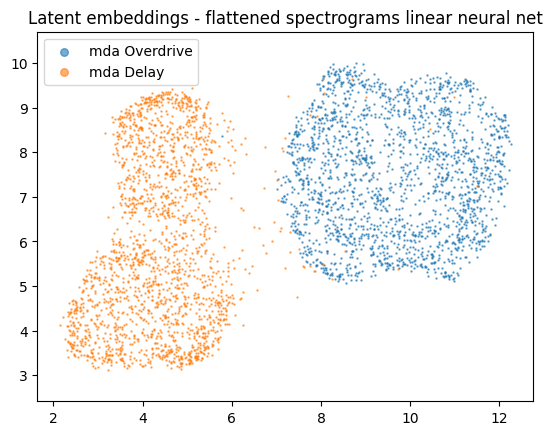

In [29]:
for fx, X in latent_embeddings.items():
    embeds = reducer.transform(X.squeeze())
    plt.scatter(x=embeds[:,0], y=embeds[:,1], label=fx, alpha=0.6, s=0.6)

plt.gca().set_aspect('equal', 'datalim')
plt.title("Latent embeddings - flattened spectrograms linear neural net")

lgnd = plt.legend()
for i in range(len(latent_embeddings.keys())):
    lgnd.legendHandles[i]._sizes = [30]

plt.savefig("./figures/latent_spectrogram_embeddings.png")